NIST Special Database Fingerprint

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
from scipy.ndimage import convolve
import cv2 as cv
import os
import glob

In [ ]:
PATH = "NISTSpecialDatabase4GrayScaleImagesofFIGS/sd04/png_txt"

imgs = glob.glob(PATH + '/**/*.png', recursive=True)
txts = glob.glob(PATH + '/**/*.txt', recursive=True)
print(f"# texts: {len(txts)}")
print(f"# images: {len(imgs)}")

# texts: 4000
# images: 4000


In [ ]:
for i in range(len(imgs)):
    imgs[i]= cv.imread(imgs[i])

In [ ]:
for i in range(len(txts)):
    with open(txts[i]) as f:
        lines = f.readlines()
        txts[i] = lines[1].split()[1]

In [ ]:
for i in range(len(imgs)):
    imgs[i] = cv.cvtColor(imgs[i], cv.COLOR_BGR2GRAY)


In [ ]:
np.unique(txts, return_counts=True)

(array(['A', 'L', 'R', 'T', 'W'], dtype='<U1'),
 array([800, 800, 800, 800, 800], dtype=int64))

This part is implementation of the Marr-Hildreth edge detection algorithm. The algorithm detects edges in an image by applying a Laplacian of Gaussian (LoG) filter to the image.

it first smoothes the picture using gaussian blur. after that it calculates the kernel and uses it in a covolutional filter.

after that the algorithm identifies zero crossings in the convolved image. A zero crossing occurs when the sign of the pixel intensity changes between adjacent pixels.

In [ ]:
def marr_hildreth(image, sigma=1.6):
    smoothed_image = cv.GaussianBlur(image, (0, 0), sigma)

    size = int(2 * np.ceil(3 * sigma) + 1)
    x, y = np.meshgrid(np.arange(-size // 2 + 1, size // 2 + 1),
                       np.arange(-size // 2 + 1, size // 2 + 1))
    log_kernel = -1 / (np.pi * sigma**4) * (1 - (x**2 + y**2) / (2 * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

    convolved_image = convolve(smoothed_image.astype(float), log_kernel)

    zero_crossings = np.zeros(convolved_image.shape)
    zero_crossings[np.where(np.diff(np.signbit(convolved_image), axis=0))] = 255
    zero_crossings[np.where(np.diff(np.signbit(convolved_image), axis=1))] = 255

    edges = zero_crossings.astype(np.uint8)

    return edges


this part implements a morphological image processing operation using rectangular structuring elements.

A rectangular structuring element is created which specifies that a rectangular kernel should be created.

after that i used erosion operation to remove small noise or thin regions.

after that i used dilation to fill in gaps, join disconnected regions, and enhance the size and connectivity of objects.

In [ ]:
def morphology_process_RECT(image):
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
    eroded_image = cv.erode(image, kernel, iterations=1)
    dilated_image = cv.dilate(eroded_image, kernel, iterations=1)
    return dilated_image

In [ ]:
mo_imgs_RECT = []
for i in range(len(imgs)):
    mo_imgs_RECT.append(morphology_process_RECT(imgs[i]))

In [ ]:
mh_imgs_RECT = []
for i in range(len(mo_imgs_RECT)):
    mh_imgs_RECT.append(marr_hildreth(mo_imgs_RECT[i]))

In [ ]:
for i in range(len(mh_imgs_RECT)):
    _, mh_imgs_RECT[i] = cv.imageold(mh_imgs_RECT[i], 127, 255, cv.image_BINARY)


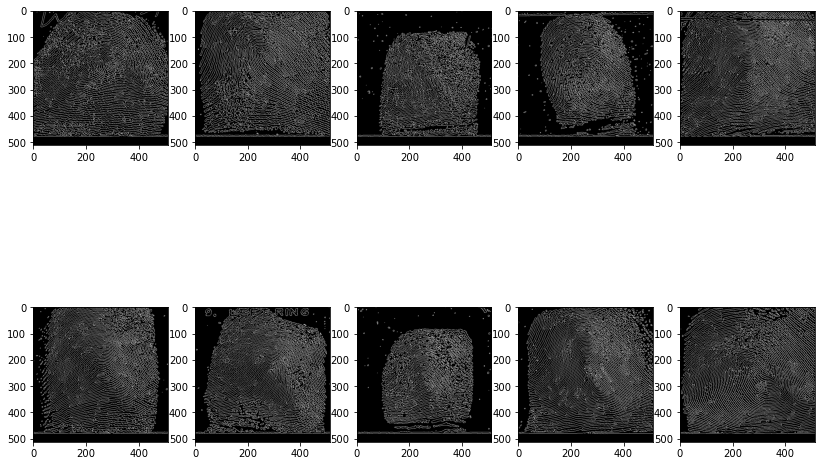

In [ ]:
ax = []
fig, ax = plt.subplots(2,5, figsize=(14,10))

for i in range(10):
    ax[i // 5][i % 5].imshow(mh_imgs_RECT[i], cmap = 'gray')
plt.show()


this function is same as above function except that it uses a ellipse like kernel.

In [ ]:
def morphology_process_ELLIPSE(image):
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    processed_image = cv.morphologyEx(image, cv.MORPH_OPEN, kernel)
    
    return processed_image

In [ ]:
mo_imgs_ELLIPSE = []
for i in range(len(imgs)):
    mo_imgs_ELLIPSE.append(morphology_process_ELLIPSE(imgs[i]))

In [ ]:
mh_imgs_ELLIPSE = []
for i in range(len(mo_imgs_ELLIPSE)):
    mh_imgs_ELLIPSE.append(marr_hildreth(mo_imgs_ELLIPSE[i]))

In [ ]:
for i in range(len(mh_imgs_RECT)):
    _, mh_imgs_ELLIPSE[i] = cv.imageold(mh_imgs_ELLIPSE[i], 127, 255, cv.image_BINARY)

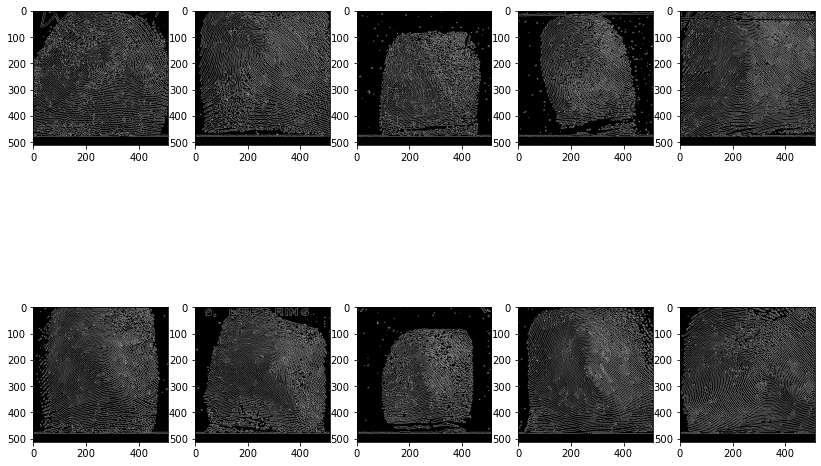

In [ ]:
ax = []
fig, ax = plt.subplots(2,5, figsize=(14,10))

for i in range(10):
    ax[i // 5][i % 5].imshow(mh_imgs_ELLIPSE[i], cmap = 'gray')
plt.show()

in this part i used canny edge detection instead of using marr hildreth.

In [ ]:
canny_imgs_ELLIPSE = []
for i in range(len(mo_imgs_ELLIPSE)):
    canny_imgs_ELLIPSE.append(cv.Canny(mo_imgs_ELLIPSE[i], 100, 200))


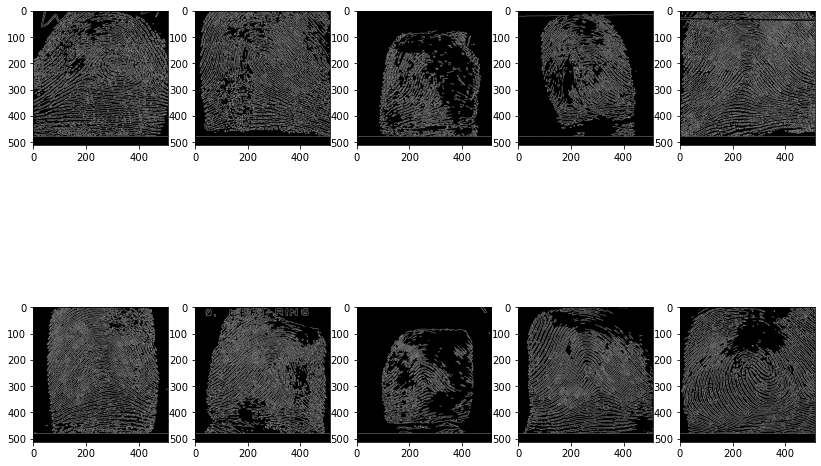

In [ ]:
ax = []
fig, ax = plt.subplots(2,5, figsize=(14,10))

for i in range(10):
    ax[i // 5][i % 5].imshow(canny_imgs_ELLIPSE[i], cmap = 'gray')
plt.show()

The provided code calculates a rotation matrix for a given input image based on its contour

first of all using the function cv.findContours from OpenCV i detected contours in the input image.

after that the code selects the contour with the largest area using the max function and the "cv.contourArea" function to determine the area of each contour. The largest contour is assumed to correspond to the object of interest.

and after that the code calculates the moments of the selected contour using the cv.moments function. Moments are statistical measures that describe the distribution of intensity values within an image and Hu moments are a set of image moments that are invariant to translation, rotation, and scale.

after that i calculated theta which is rotation angle. This angle represents the rotation required to align the major axis of the contour with the x-axis.

and at last i computed rotation matrix using theta and returned it.

In [604]:
def get_rotation_matrix(image):
    

    contours, _ = cv.findContours(image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    cnt = max(contours, key=cv.contourArea)
    
    x,y,w,h = cv.boundingRect(cnt)
    
    cropped = image[y:y+h, x:x+w]
    
    moments = cv.moments(cnt)
    hu_moments = cv.HuMoments(moments)
    theta = -np.arctan2(hu_moments[1], hu_moments[0]) * 180 / np.pi
    
    center = (w//2, h//2)
    M = cv.getRotationMatrix2D(center, int(theta), 1)
    
    return M

this part is a train-like part that computes rotation matrix for first 3500 pictures to compute distance their rotation matrix on remaining pictures and predict them.

In [605]:
W = []
R = []
L = []
A = []
T = []
for i in range(3500):
    if txts[i] == 'W':
        W.append(get_rotation_matrix(mh_imgs_RECT[i]))
    elif txts[i] == 'R':
        R.append(get_rotation_matrix(mh_imgs_RECT[i]))
    elif txts[i] == 'L':
        L.append(get_rotation_matrix(mh_imgs_RECT[i]))
    elif txts[i] == 'A':
        A.append(get_rotation_matrix(mh_imgs_RECT[i]))
    elif txts[i] == 'T':
        T.append(get_rotation_matrix(mh_imgs_RECT[i]))



In [606]:
arr = []

In [607]:
for i in range(3500, 4000):
    dist_w = 0
    dist_r = 0
    dist_l = 0
    dist_a = 0
    dist_t = 0
    rm = get_rotation_matrix(mh_imgs_RECT[i])


    for j in range(len(W)):
        dist_w += np.sum(np.abs(W[j] - rm))
    for j in range(len(R)):
        dist_r += np.sum(np.abs(R[j] - rm))
    for j in range(len(L)):
        dist_l += np.sum(np.abs(L[j] - rm))
    for j in range(len(A)):
        dist_a += np.sum(np.abs(A[j] - rm))
    for j in range(len(T)):
        dist_t += np.sum(np.abs(T[j] - rm))


    min_dist = min(dist_w, dist_r, dist_l, dist_a, dist_t)

    if min_dist == dist_w:
        arr.append('W')
    elif min_dist == dist_r:
        arr.append('R')
    elif min_dist == dist_l:
        arr.append('L')
    elif min_dist == dist_a:
        arr.append('A')
    elif min_dist == dist_t:
        arr.append('T')


In [608]:
wrong = 0
right = 0
for i in range(3500, 4000):
    if arr[i - 3500] == txts[i]:
        right += 1
    else:
        wrong += 1

In [609]:
wrong

363

In [610]:
right

137

In [611]:
print('accuracy : ', float((right) / wrong) * 100)

accuracy :  37.74104683195592


In [612]:
W = []
R = []
L = []
A = []
T = []
for i in range(3500):
    if txts[i] == 'W':
        W.append(get_rotation_matrix(canny_imgs_ELLIPSE[i]))
    elif txts[i] == 'R':
        R.append(get_rotation_matrix(canny_imgs_ELLIPSE[i]))
    elif txts[i] == 'L':
        L.append(get_rotation_matrix(canny_imgs_ELLIPSE[i]))
    elif txts[i] == 'A':
        A.append(get_rotation_matrix(canny_imgs_ELLIPSE[i]))
    elif txts[i] == 'T':
        T.append(get_rotation_matrix(canny_imgs_ELLIPSE[i]))



In [613]:
arr = []

In [614]:
for i in range(3500, 4000):
    dist_w = 0
    dist_r = 0
    dist_l = 0
    dist_a = 0
    dist_t = 0
    rm = get_rotation_matrix(mh_imgs_RECT[i])


    for j in range(len(W)):
        dist_w += np.sum(np.abs(W[j] - rm))
    for j in range(len(R)):
        dist_r += np.sum(np.abs(R[j] - rm))
    for j in range(len(L)):
        dist_l += np.sum(np.abs(L[j] - rm))
    for j in range(len(A)):
        dist_a += np.sum(np.abs(A[j] - rm))
    for j in range(len(T)):
        dist_t += np.sum(np.abs(T[j] - rm))


    min_dist = min(dist_w, dist_r, dist_l, dist_a, dist_t)

    if min_dist == dist_w:
        arr.append('W')
    elif min_dist == dist_r:
        arr.append('R')
    elif min_dist == dist_l:
        arr.append('L')
    elif min_dist == dist_a:
        arr.append('A')
    elif min_dist == dist_t:
        arr.append('T')


In [615]:
wrong = 0
right = 0
for i in range(3500, 4000):
    if arr[i - 3500] == txts[i]:
        right += 1
    else:
        wrong += 1

In [616]:
wrong

369

In [617]:
right

131

In [618]:
print('accuracy : ', float((right) / wrong) * 100)

accuracy :  35.50135501355013


And the best accuracy was 37.74 percent.